## Current Python Version

Ensure the python version running in the jupyter kernel is the same as expected

In [1]:
# from platform import python_version

# print(python_version())


List installed packages, should match the ones in the pipfile (and their dependencies)

In [2]:
# pip list

## Internal Module Imports
Code required to enable project's internally defined modulos into the jupyter notebook environment

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from electricity import ElectricalSystem, Load, Generator
from dto import (
    COST_PRESETS, 
    ElectricalSystemSpecs, 
    EpsilonSpecs,
    GeneratorSpecs, 
    LoadSpecs, 
    NodeStatePower, 
    SystemHistory, 
    )
    
from learning import ModelTrainer, ModelTester, LearningParams

/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

Determine the experiment params

In [5]:
from dto import EpsilonSpecs, ElectricalConstants
import math

LearningParams(
    gamma=0.9,   # Gamma (Discount)
    tau=0.001, # Tau
    epsilonSpecs = EpsilonSpecs( # Epsilon explore/exploit control
        thresholdProgress = 0.6, # % of steps where decay change should happen
        thresholdValue = 0.5, # Value at which decay change would happen
        finalValue = 0.0001, # Value at the end of the experiment
    ),
    numEpisodes=500, # Number of learning episodes to run
    maxSteps=100,   # Number of steps per learning episode
    bufferSize=500, # Experience Buffer Size
    traceLength=15,     # Number of steps each sampled episode should contain
    batchSize=40,     # Number of episodes sampled from experience buffer
    updateInterval=4, # Run update cycle every N steps
    electricalSystemSpecs = ElectricalSystemSpecs(
        loads=[LoadSpecs(id_="L1", basePower=4.0, noiseLevel=0.05)],
        generators=[
            GeneratorSpecs(id_="G1", basePower=1.0, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.0, noiseLevel=0.05),
            GeneratorSpecs(id_="G2", basePower=1.0, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.0, noiseLevel=0.05),
#             GeneratorSpecs(id_="G3", basePower=1.0, costProfile=COST_PRESETS.GAS, minPower=0.5, maxPower=2.0, noiseLevel=0.05),
        ],
        shouldTrackOptimalCost=True,
    ),
    modelName='3Gens-CostFrequency-0_5k-c2'
)

# Droop = +infinity essentially remove the droop component from the power update equation. System reacts as if droop is disabled
# ElectricalConstants().droop = math.inf

LearningParams(electricalSystemSpecs=ElectricalSystemSpecs(loads=[LoadSpecs(id_='L1', basePower=4.0, noiseLevel=0.05)], generators=[GeneratorSpecs(id_='G1', basePower=1.0, costProfile=CostProfile(alpha=300.0, beta=5, gamma=0.001), minPower=0.5, maxPower=2.0, noiseLevel=0.05), GeneratorSpecs(id_='G2', basePower=1.0, costProfile=CostProfile(alpha=500.0, beta=8, gamma=0.00194), minPower=0.5, maxPower=2.0, noiseLevel=0.05)], shouldTrackOptimalCost=True), gamma=0.9, tau=0.001, epsilonSpecs=EpsilonSpecs(thresholdProgress=0.6, thresholdValue=0.5, finalValue=0.0001), numEpisodes=500, maxSteps=100, bufferSize=500, traceLength=15, batchSize=40, updateInterval=4, nnShape=NeuralNetworkShape(layer_00_ltsm=100, layer_01_mlp_01=1000, layer_02_mlp_02=100, layer_03_mlp_03=50, layer_04_mlp_04=1), modelName='3Gens-CostFrequency-0_5k-c2')

Train Agents

In [18]:
def rewardFn(deltaFreq, totalCost):
    scaledCost = totalCost/(10000.0) # Scale down cost to levels near the ones found in output differential (e.g. 10 */ 10)
    costComponent = 2**(-1*(scaledCost**2)/50)
    freqComponent = 8*2**(-1*(deltaFreq**2)/2) + 2**(-1*(deltaFreq**2)/100)
    earnedReward = costComponent*freqComponent
    
    print(f'Scaled_Cost:{scaledCost} - deltaFreq:{deltaFreq} - costComponent:{costComponent} - freqComponent:{freqComponent} - reward:{earnedReward}')

    return earnedReward, {'cost': costComponent, 'freq': freqComponent, 'total': earnedReward}

In [19]:
from learning.cost_frequency import ModelAdapterCostFrequency as ModelAdapter
modelAdapter = ModelAdapter(rewardFn=rewardFn)

In [8]:
%%time
allAgents = ModelTrainer(modelAdapter).trainAgents()

W0916 01:58:03.218603 139677962667776 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0916 01:58:03.220238 139677962667776 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:29: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0916 01:58:03.251502 139677962667776 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:38: dyna

Training model: 3Gens-CostFrequency-0_5k-c2 - 0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100%
Model saved in path: /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/models/3Gens-CostFrequency-0_5k-c2/model
CPU times: user 1h 28min 17s, sys: 9min 12s, total: 1h 37min 29s
Wall time: 1h 13min 25s


In [20]:
STEPS_TO_TEST = 300

# testSpecs = ElectricalSystemSpecs(
#         loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.1)],
#         generators=[
#             GeneratorSpecs(id_="G1", basePower=1.5, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#             GeneratorSpecs(id_="G2", basePower=1.5, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#         ],
# )
# electricalSystem, rewards = ModelTester.testAgents(testSpecs, LearningParams().modelName, STEPS_TO_TEST)


electricalSystem, rewards = ModelTester(modelAdapter).testAgents(LearningParams().electricalSystemSpecs, LearningParams().modelName, STEPS_TO_TEST)

Scaled_Cost:0.20910952854610831 - deltaFreq:27.88585572237882 - costComponent:0.9993940015988498 - freqComponent:0.004561710181345288 - reward:0.0045589457922688825
Scaled_Cost:0.21224426895332002 - deltaFreq:-28.03192455750363 - costComponent:0.9993757022046147 - freqComponent:0.004310622845791305 - reward:0.00430793173345194
Scaled_Cost:0.19869080521417143 - deltaFreq:19.462971106508405 - costComponent:0.9994528679433499 - freqComponent:0.07238966534939367 - reward:0.07235005864291084
Scaled_Cost:0.20186555115939928 - deltaFreq:-7.6406653979889185 - costComponent:0.9994352487284666 - freqComponent:0.6672051598248306 - reward:0.6668283548624458
Scaled_Cost:0.1883520874734776 - deltaFreq:-4.894968947960848 - costComponent:0.9995083120763572 - freqComponent:0.848955774513917 - reward:0.8485383532118816
Scaled_Cost:0.17489742378930834 - deltaFreq:12.854753978988043 - costComponent:0.9995760348075738 - freqComponent:0.31810015972459127 - reward:0.3179652963291628
Scaled_Cost:0.16150156010

Scaled_Cost:0.224485 - deltaFreq:-0.10272027858534472 - costComponent:0.9993016415059492 - freqComponent:8.97072544390345 - reward:8.964460661591904
Scaled_Cost:0.224485 - deltaFreq:-0.13120258361330173 - costComponent:0.9993016415059492 - freqComponent:8.952295106609341 - reward:8.946043195280392
Scaled_Cost:0.224485 - deltaFreq:-0.1752145670502827 - costComponent:0.9993016415059492 - freqComponent:8.915119575707166 - reward:8.908893626225993
Scaled_Cost:0.224485 - deltaFreq:-0.08489530732045836 - costComponent:0.9993016415059492 - freqComponent:8.979992342449437 - reward:8.973721088520577
Scaled_Cost:0.224485 - deltaFreq:-0.18704497995716451 - costComponent:0.9993016415059492 - freqComponent:8.903341932255243 - reward:8.897124207791414
Scaled_Cost:0.224485 - deltaFreq:-0.10443571863240919 - costComponent:0.9993016415059492 - freqComponent:8.969741360410747 - reward:8.963477265342267
Scaled_Cost:0.224485 - deltaFreq:-0.1476069900738608 - costComponent:0.9993016415059492 - freqComponen

Scaled_Cost:0.224485 - deltaFreq:-0.13767712123593157 - costComponent:0.9993016415059492 - freqComponent:8.947486477314266 - reward:8.941237924132428
Scaled_Cost:0.224485 - deltaFreq:-0.13734800634081523 - costComponent:0.9993016415059492 - freqComponent:8.94773642580943 - reward:8.941487698073939
Scaled_Cost:0.224485 - deltaFreq:-0.1374475987873396 - costComponent:0.9993016415059492 - freqComponent:8.947660851961068 - reward:8.941412177003215
Scaled_Cost:0.224485 - deltaFreq:-0.13756279561381035 - costComponent:0.9993016415059492 - freqComponent:8.947573369590051 - reward:8.941324755726257
Scaled_Cost:0.224485 - deltaFreq:-0.13730605939215934 - costComponent:0.9993016415059492 - freqComponent:8.947768240278524 - reward:8.941519490325128
Scaled_Cost:0.224485 - deltaFreq:-0.1376044702007846 - costComponent:0.9993016415059492 - freqComponent:8.947541703404308 - reward:8.941293111654863
Scaled_Cost:0.224485 - deltaFreq:-0.13735736617825722 - costComponent:0.9993016415059492 - freqComponen

Scaled_Cost:0.224485 - deltaFreq:-0.13745753545683925 - costComponent:0.9993016415059492 - freqComponent:8.947653308740783 - reward:8.941404639050802
Scaled_Cost:0.224485 - deltaFreq:-0.13745787423795264 - costComponent:0.9993016415059492 - freqComponent:8.947653051552514 - reward:8.941404382042144
Scaled_Cost:0.224485 - deltaFreq:-0.13745817078366684 - costComponent:0.9993016415059492 - freqComponent:8.947652826427056 - reward:8.941404157073904
Scaled_Cost:0.224485 - deltaFreq:-0.13745744296694795 - costComponent:0.9993016415059492 - freqComponent:8.947653378955081 - reward:8.941404709216066
Scaled_Cost:0.224485 - deltaFreq:-0.13745831330534486 - costComponent:0.9993016415059492 - freqComponent:8.947652718230218 - reward:8.941404048952625
Scaled_Cost:0.224485 - deltaFreq:-0.1374575755759082 - costComponent:0.9993016415059492 - freqComponent:8.947653278284118 - reward:8.941404608615407
Scaled_Cost:0.224485 - deltaFreq:-0.13745799512806656 - costComponent:0.9993016415059492 - freqCompon

Scaled_Cost:0.224485 - deltaFreq:-0.13745788071516785 - costComponent:0.9993016415059492 - freqComponent:8.94765304663528 - reward:8.941404377128343
Scaled_Cost:0.224485 - deltaFreq:-0.13745788146220406 - costComponent:0.9993016415059492 - freqComponent:8.947653046068162 - reward:8.941404376561621
Scaled_Cost:0.224485 - deltaFreq:-0.1374578794048773 - costComponent:0.9993016415059492 - freqComponent:8.947653047629998 - reward:8.941404378122368
Scaled_Cost:0.224485 - deltaFreq:-0.13745788193913455 - costComponent:0.9993016415059492 - freqComponent:8.947653045706096 - reward:8.941404376199808
Scaled_Cost:0.224485 - deltaFreq:-0.13745787974072243 - costComponent:0.9993016415059492 - freqComponent:8.947653047375038 - reward:8.941404377867585
Scaled_Cost:0.224485 - deltaFreq:-0.1374578810391398 - costComponent:0.9993016415059492 - freqComponent:8.947653046389334 - reward:8.941404376882568
Scaled_Cost:0.224485 - deltaFreq:-0.13745788084200683 - costComponent:0.9993016415059492 - freqComponen

Scaled_Cost:0.224485 - deltaFreq:-0.13745788066096054 - costComponent:0.9993016415059492 - freqComponent:8.947653046676432 - reward:8.941404377169468
Scaled_Cost:0.224485 - deltaFreq:-0.13745788066465536 - costComponent:0.9993016415059492 - freqComponent:8.947653046673627 - reward:8.941404377166664
Scaled_Cost:0.224485 - deltaFreq:-0.13745788066648856 - costComponent:0.9993016415059492 - freqComponent:8.947653046672235 - reward:8.941404377165272
Scaled_Cost:0.224485 - deltaFreq:-0.13745788066068343 - costComponent:0.9993016415059492 - freqComponent:8.947653046676642 - reward:8.941404377169675
Scaled_Cost:0.224485 - deltaFreq:-0.13745788066805886 - costComponent:0.9993016415059492 - freqComponent:8.947653046671043 - reward:8.941404377164082
Scaled_Cost:0.224485 - deltaFreq:-0.13745788066151476 - costComponent:0.9993016415059492 - freqComponent:8.947653046676011 - reward:8.941404377169047
Scaled_Cost:0.224485 - deltaFreq:-0.13745788066551512 - costComponent:0.9993016415059492 - freqCompo

Alternatively, one can plot the data to better inspect the progression

In [10]:
import matplotlib.pyplot as plt
from learning.learning_state import LearningState
from plots import plotAll, plotExperimentRewardProgression

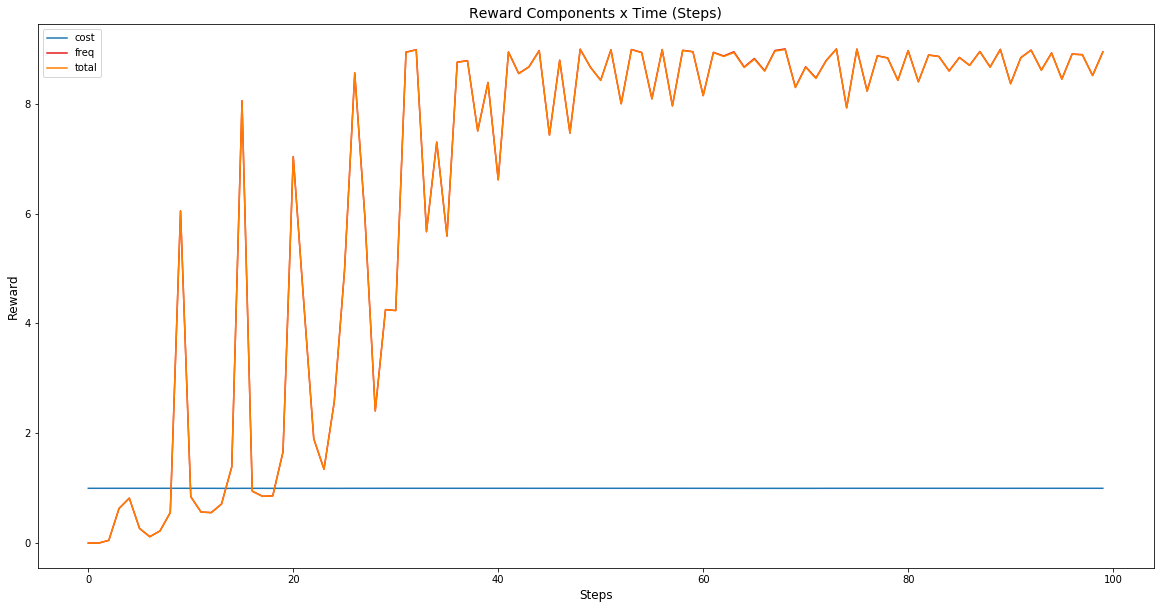

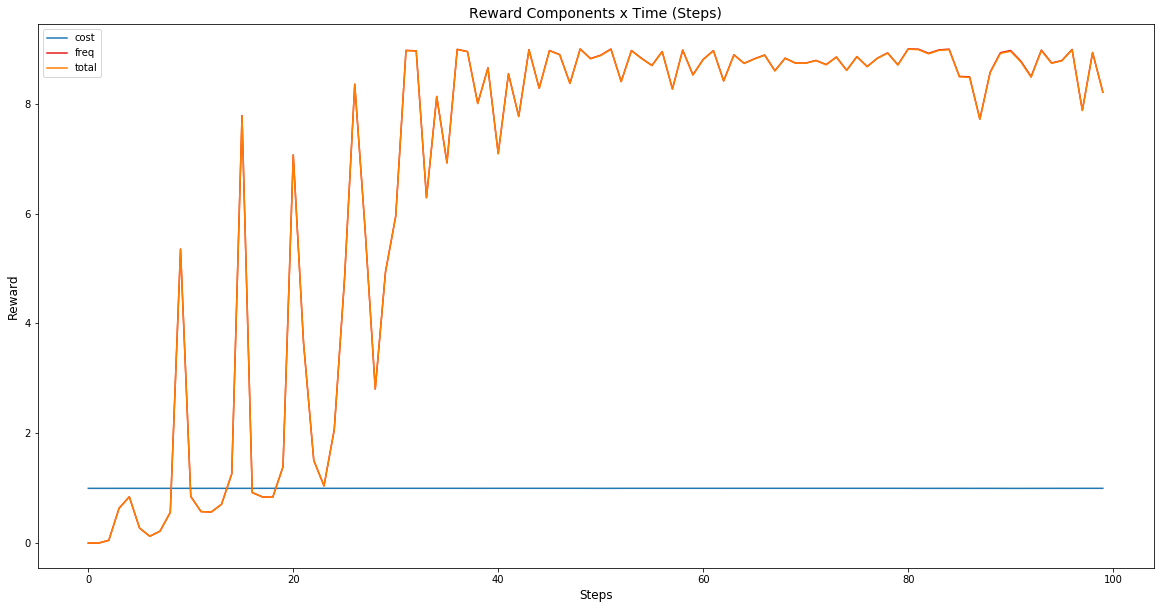

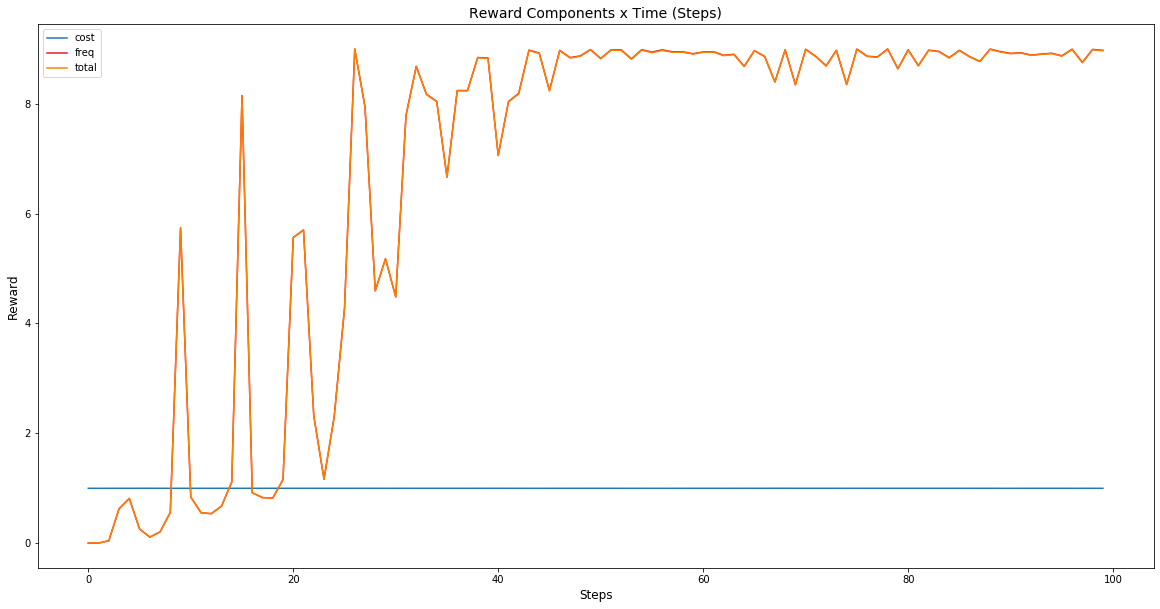

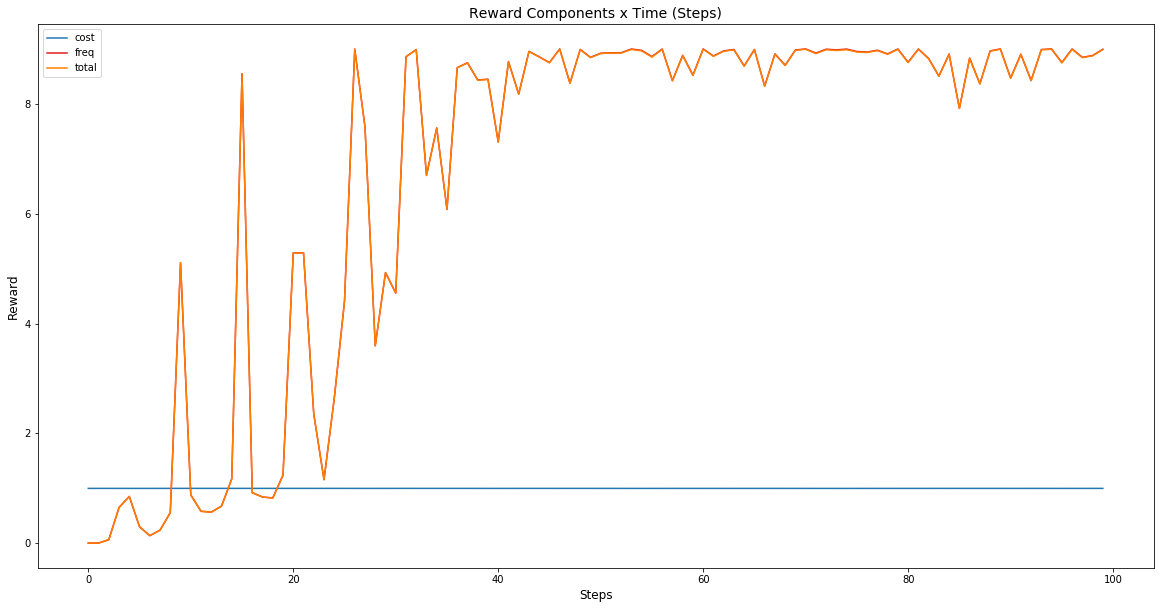

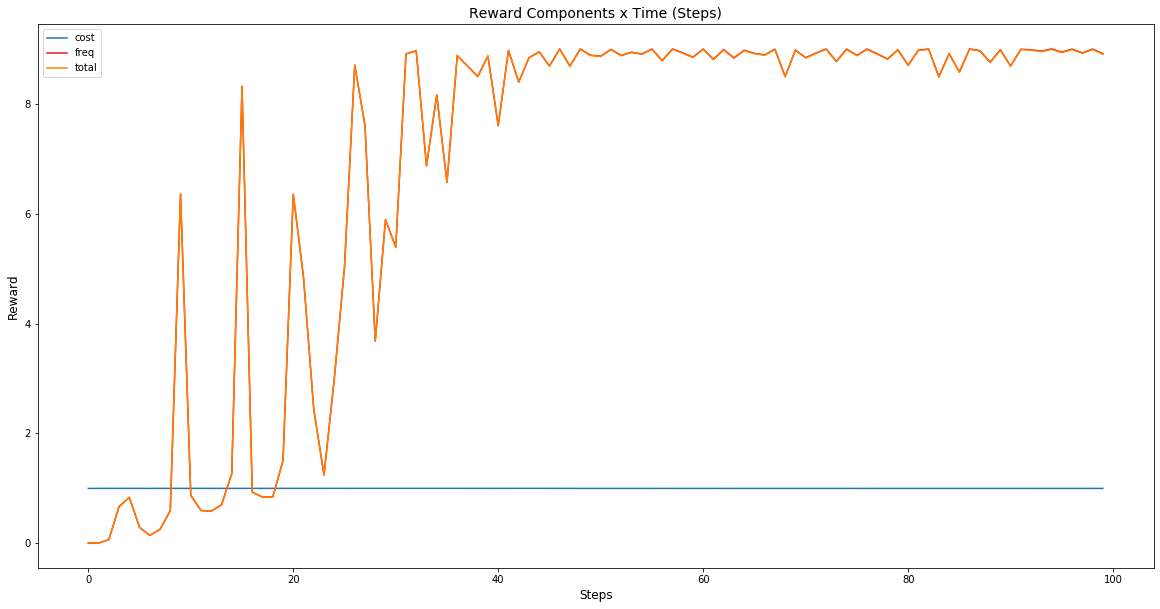

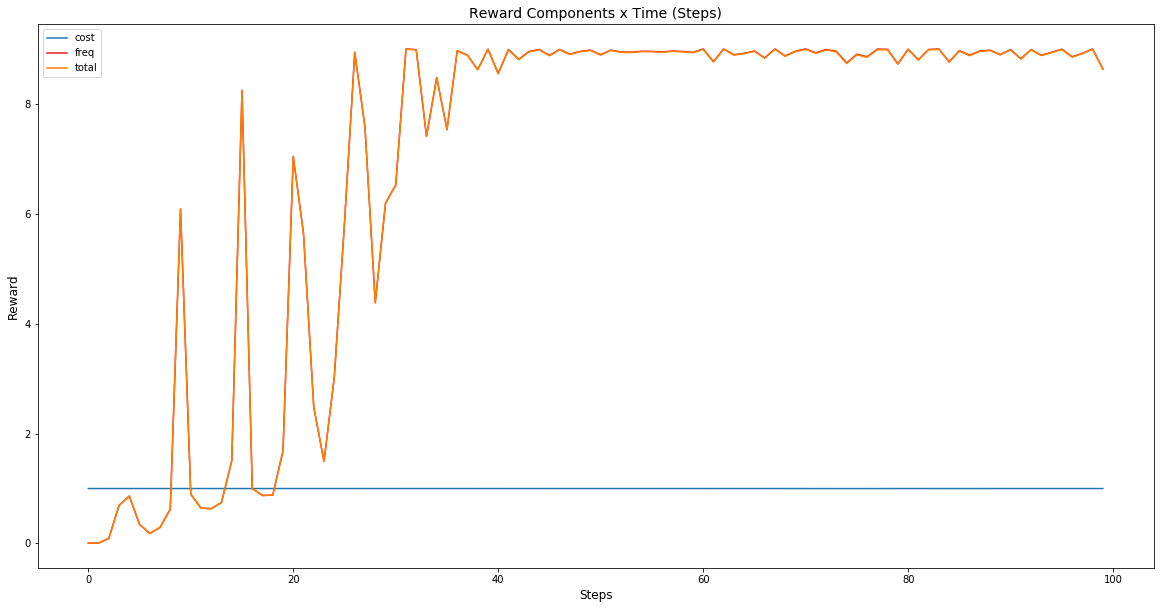

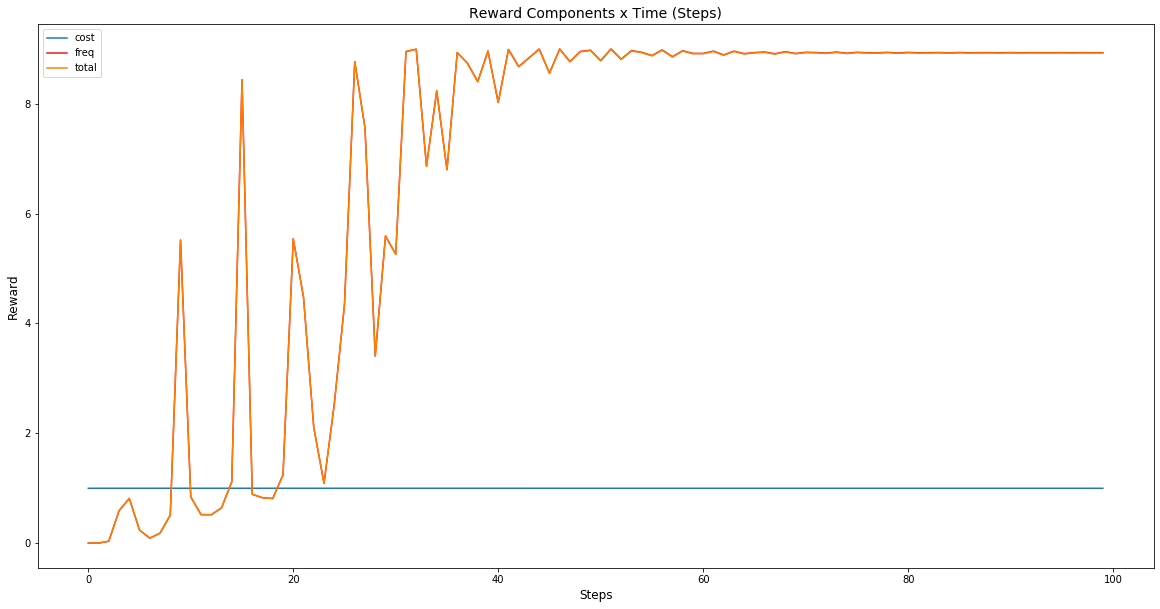

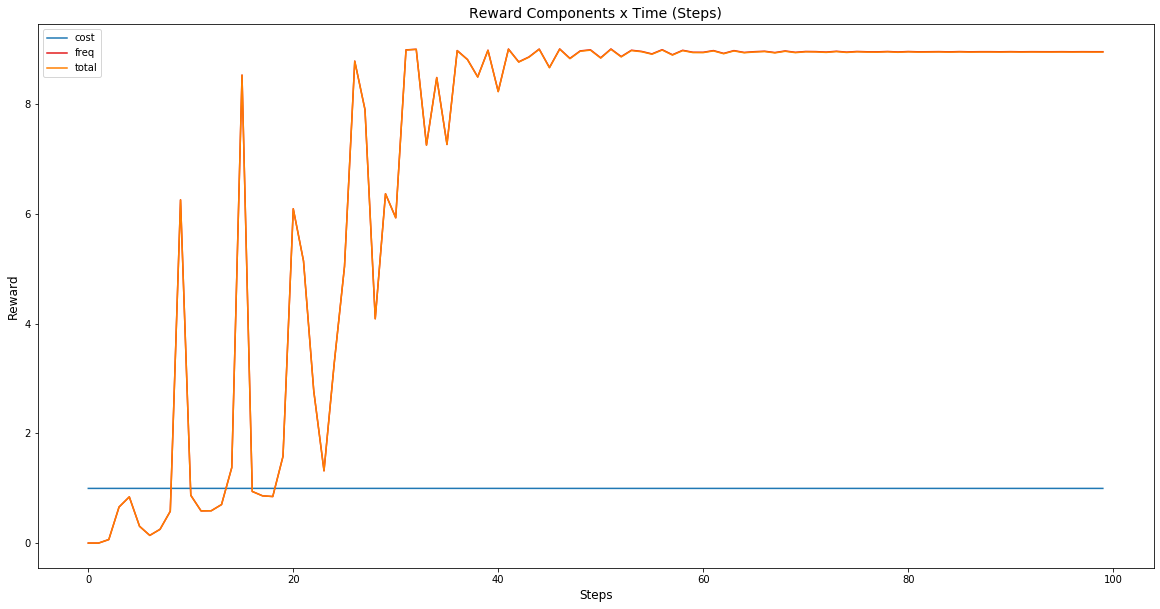

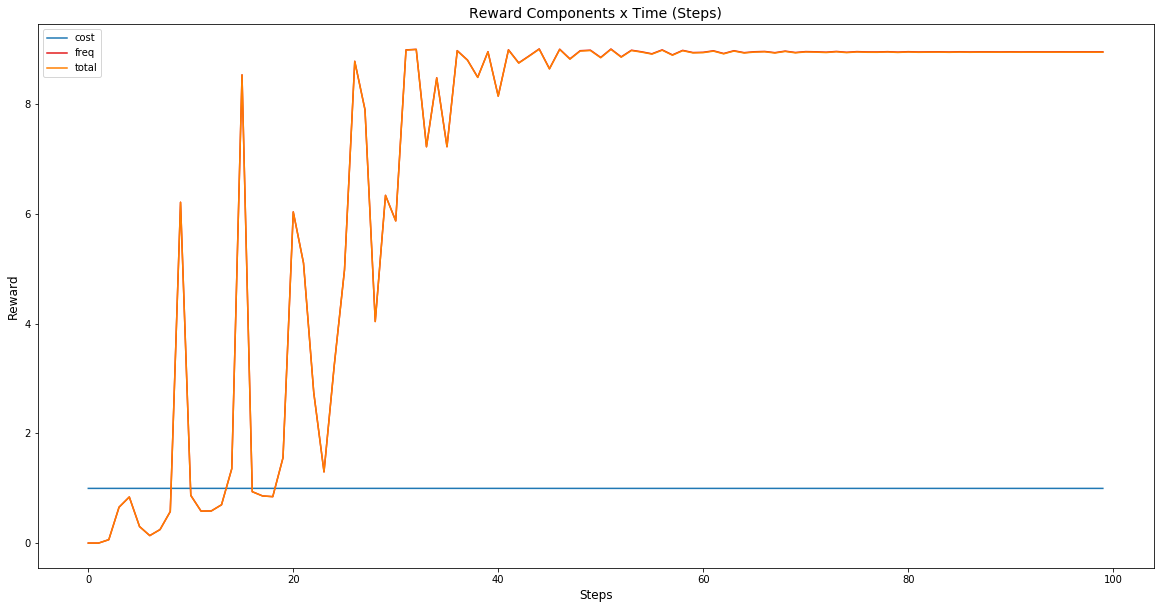

In [11]:
plotExperimentRewardProgression(LearningState().model.allRewards)

Plot the reward progression of the model testing

2481.9497091781964

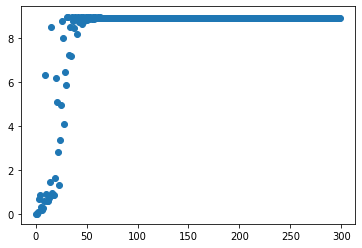

In [12]:
steps = range(STEPS_TO_TEST)
plt.scatter(steps, rewards)
sum(rewards)

Plot all graphs related to the electrical system state during the model testing

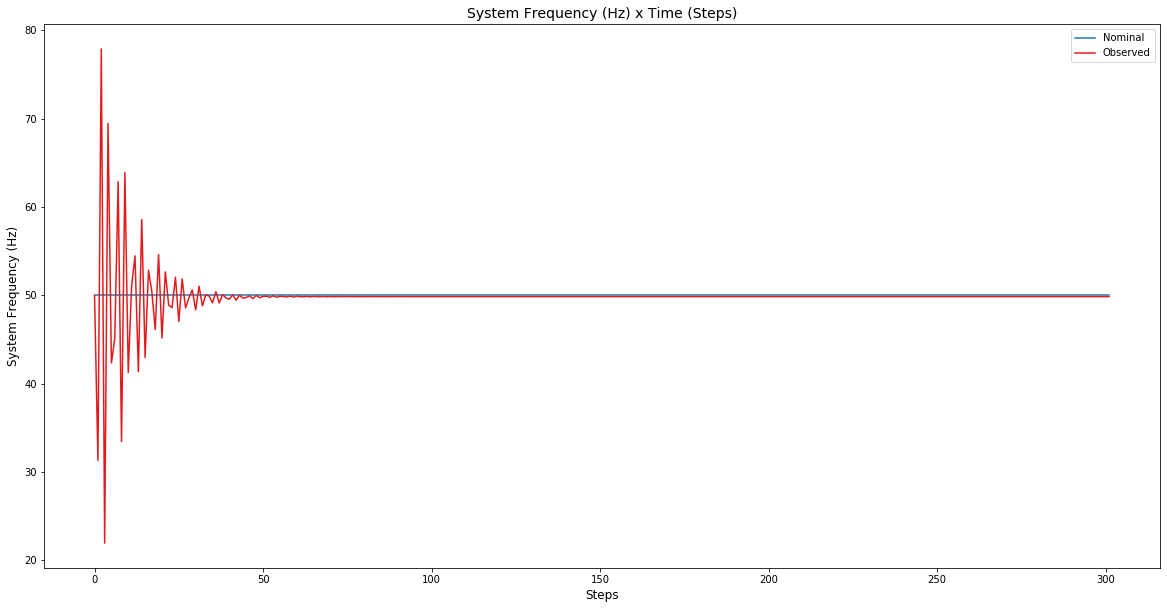

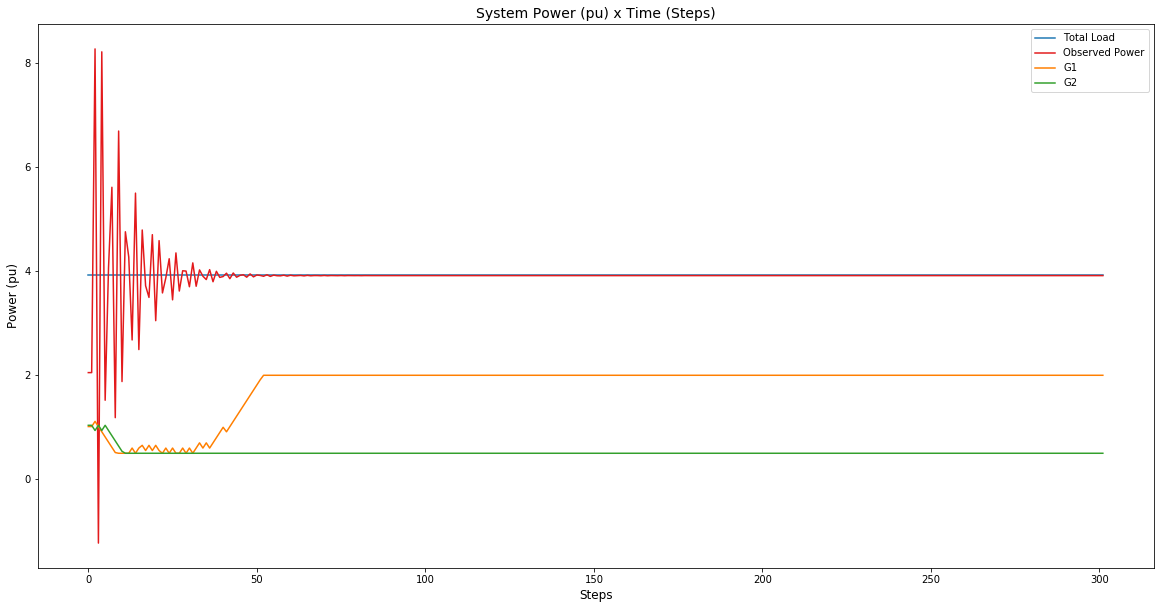

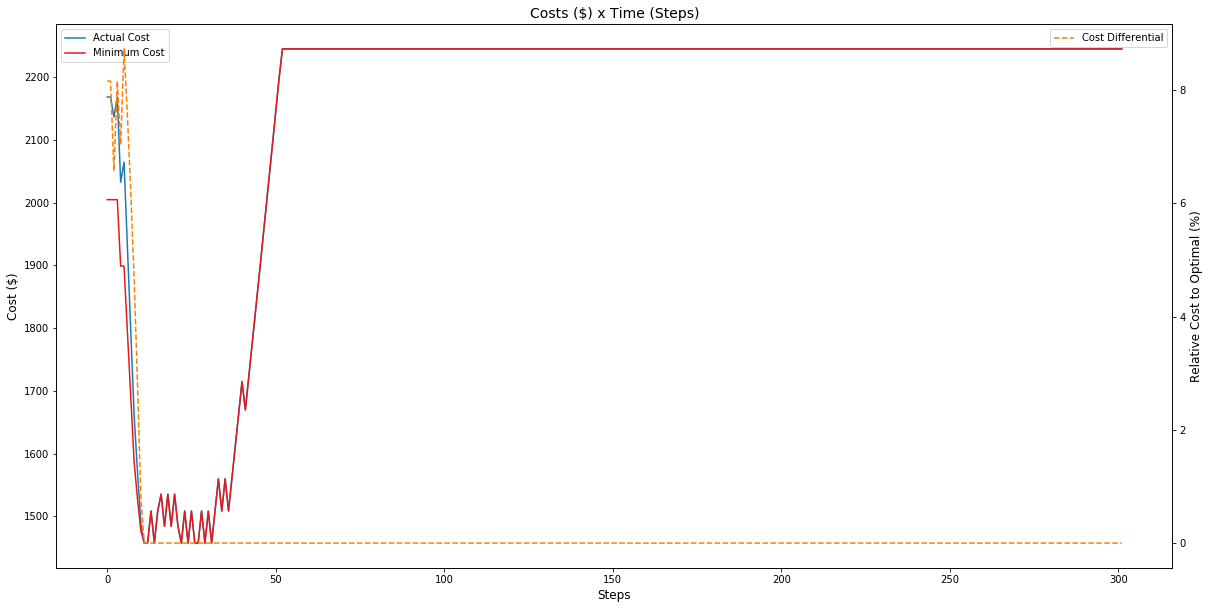

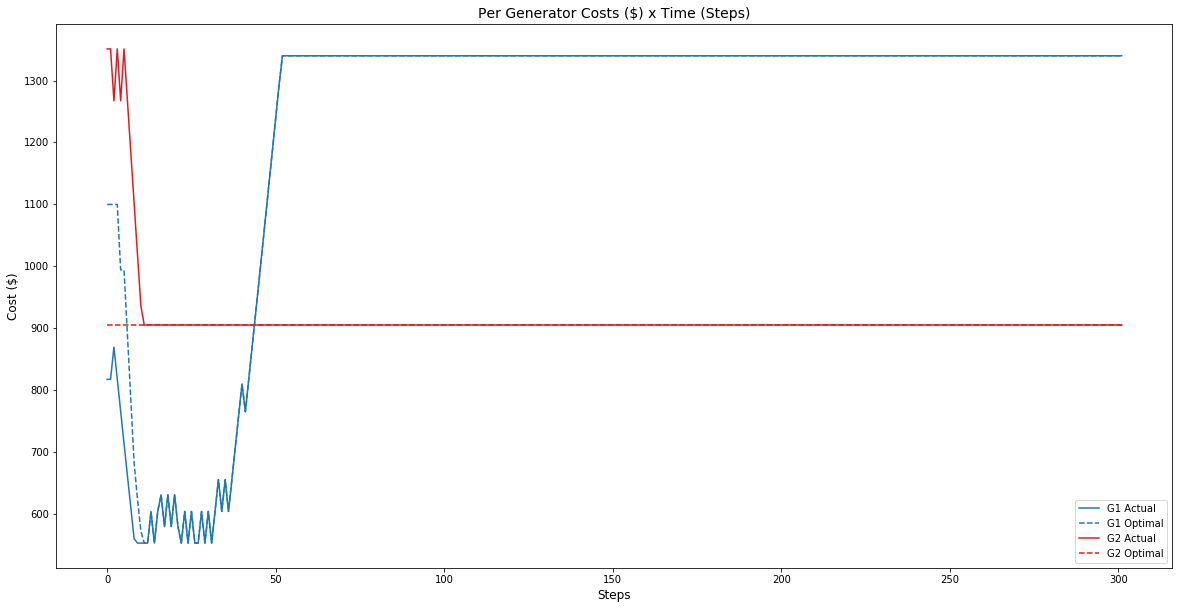

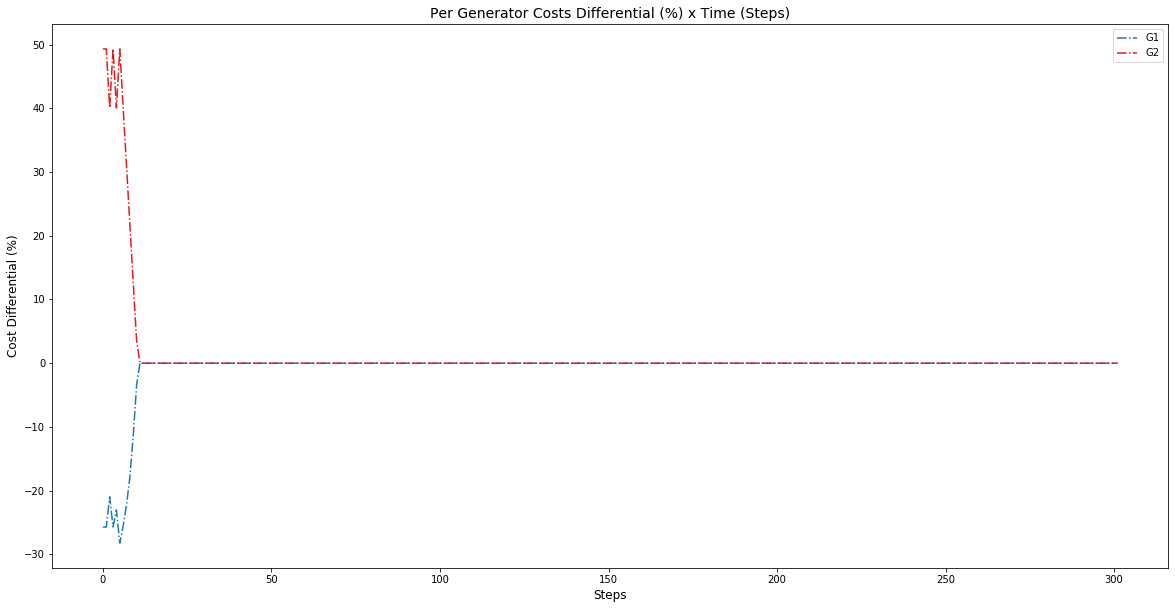

In [13]:
plotAll(electricalSystem.systemHistory)

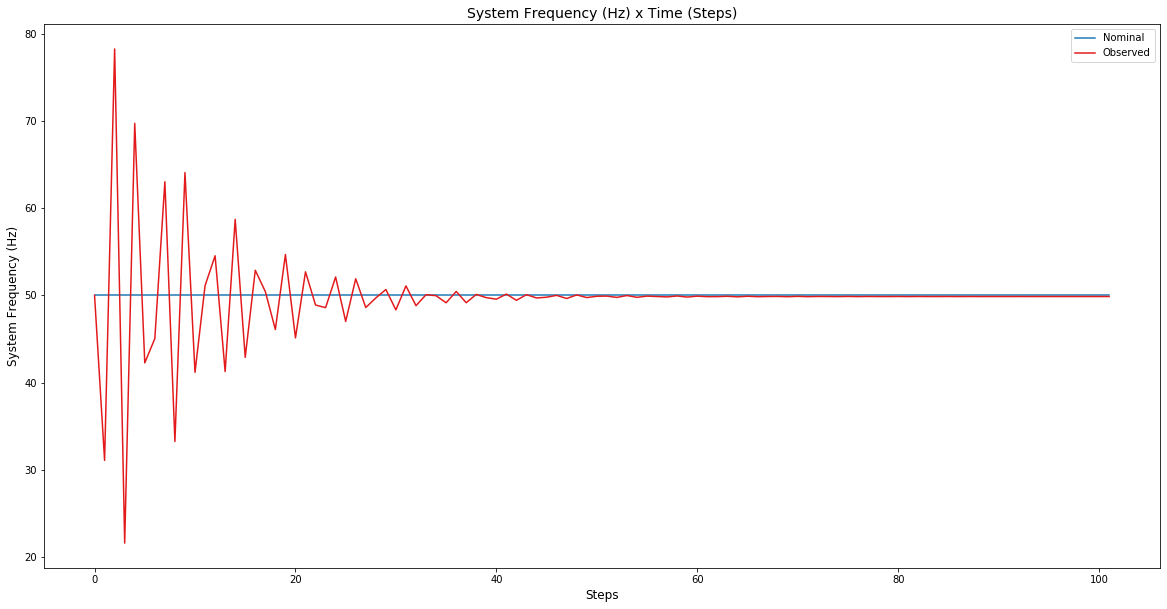

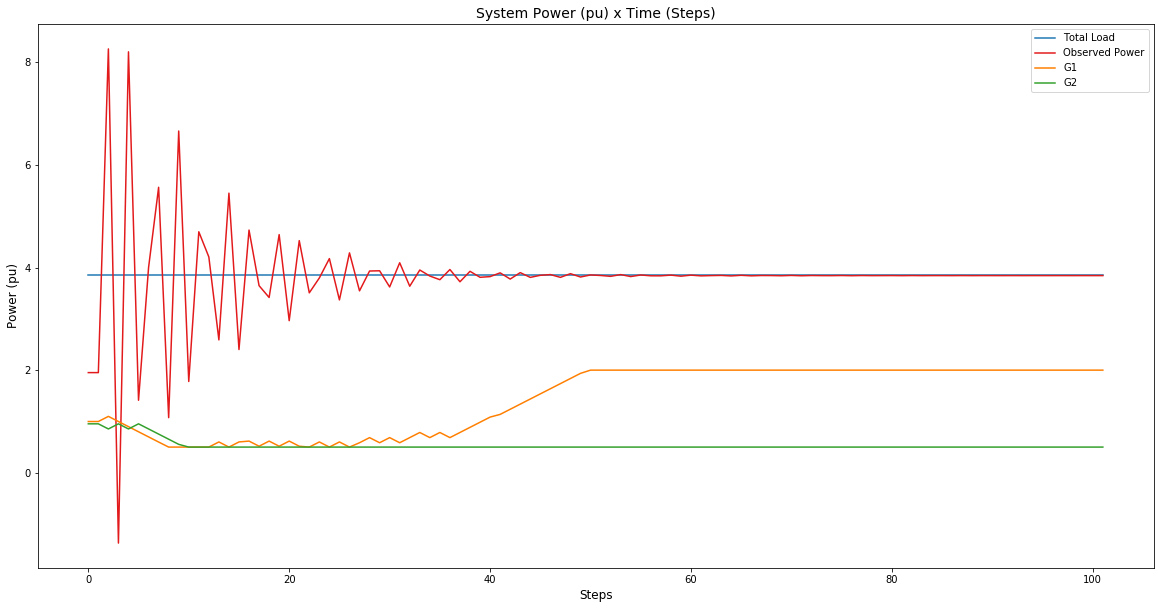

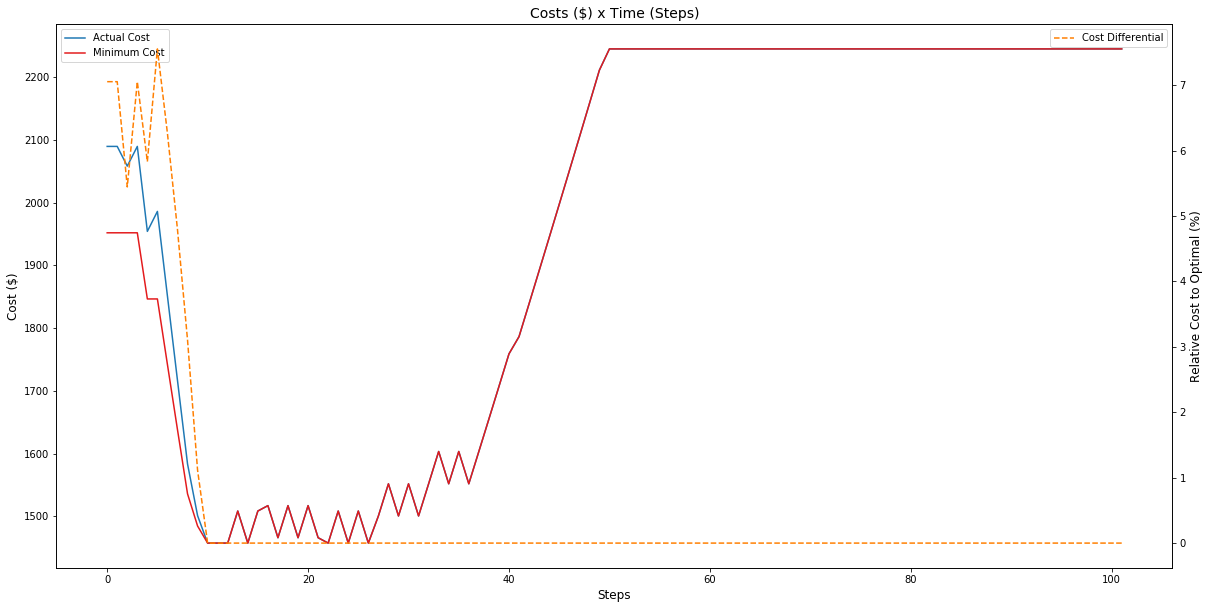

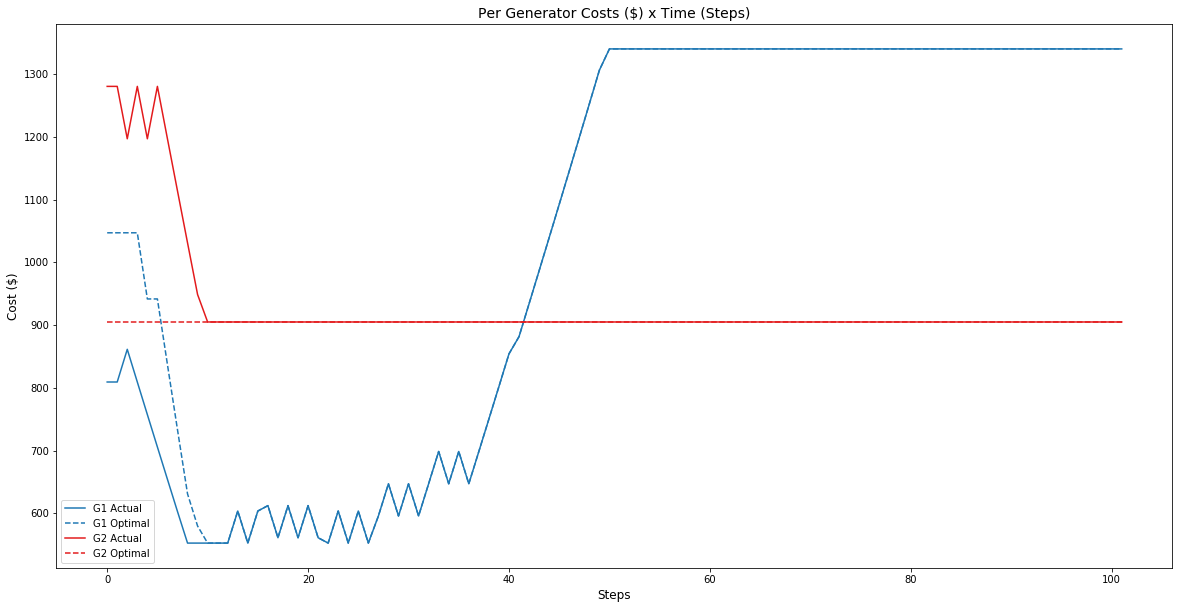

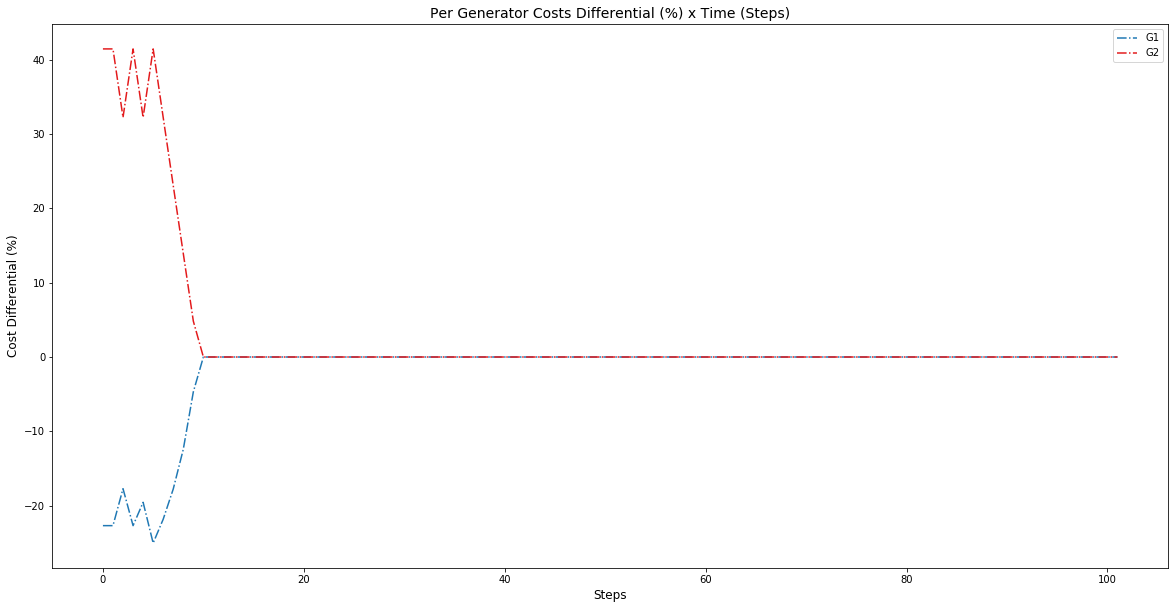

In [14]:
# # Show the last episode ran during training
from learning.learning_state import LearningState
plotAll(LearningState().episode.electricalSystem.systemHistory)

In [15]:
from learning.learning_state import LearningState
import numpy as np

rewList = LearningState().model.cummRewardList

In [16]:
LearningState().model.allRewards

[[{'cost': 0.9993369336500033,
   'freq': 0.0021860358106295863,
   'total': 0.00218458632384367},
  {'cost': 0.9994519991642783,
   'freq': 0.0020269674871826703,
   'total': 0.0020258567073057135},
  {'cost': 0.9996014985232758,
   'freq': 0.05179240441567554,
   'total': 0.0517717650660328},
  {'cost': 0.9996079918634458,
   'freq': 0.6323270064556353,
   'total': 0.6320791291241418},
  {'cost': 0.9996845041221115,
   'freq': 0.8209878114243502,
   'total': 0.8207287931540491},
  {'cost': 0.9996950676716025,
   'freq': 0.2691827138802184,
   'total': 0.2691006313685106},
  {'cost': 0.9995752279081799,
   'freq': 0.1179897277133453,
   'total': 0.11793960896989122},
  {'cost': 0.9996689445550353,
   'freq': 0.22436345186111956,
   'total': 0.22428917511872987},
  {'cost': 0.999705612575519,
   'freq': 0.5585298183439189,
   'total': 0.5583653941892008},
  {'cost': 0.9996498762226841,
   'freq': 6.051649839908065,
   'total': 6.049531013407123},
  {'cost': 0.9994795696774256,
   'freq

TypeError: float() argument must be a string or a number, not 'dict'

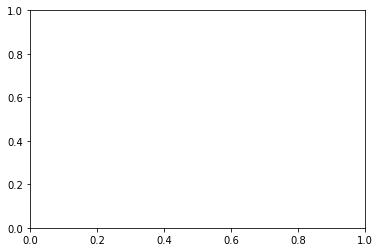

In [17]:
allRewards = LearningState().model.allRewards


for r in allRewards:
    plt.figure()
    plt.scatter(range(len(r)), r)
# sum(rewards)

In [ ]:
plt.scatter(range(len(rewList)), rewList)

In [ ]:
from plots.plot_constants import COLOR_PALETTE, FONT_SIZES

history = electricalSystem.systemHistory
# Get series to be plotted
stepsSeries = history.steps
loads = history.loads
totalLoadSeries = history.totalLoad
generators = history.generators
totalPowerSeries = history.totalPower

plt.figure(0)

# Declare colors to be used
colorTotalLoad = COLOR_PALETTE[0]
colorTotalPower = COLOR_PALETTE[1]
colorsIndividualNodes = COLOR_PALETTE[3:]

# Plot total power/load data
plt.plot(stepsSeries, totalLoadSeries, color=colorTotalLoad)
plt.plot(stepsSeries, totalPowerSeries, color=colorTotalPower)
legendFields = ['Total Load', 'Total Power']

# Multiple scenarios involve a single load, so we make it optional to plot that single load
if(False):
    for idx, loadId in enumerate(loads):
        # Since num loads is variable, colors may wrap around the palette
        loadColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
        loadLegend = loadId
        loadSeries = loads[loadId]
        plt.plot(stepsSeries, loadSeries, color=loadColor, linestyle='--')
        legendFields.append(loadLegend)

for idx, generatorId in enumerate(generators):
    # Since num generators is variable, colors may wrap around the palette
    generatorColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
    generatorLegend = generatorId
    generatorSeries = generators[generatorId]
    plt.plot(stepsSeries, generatorSeries, color=generatorColor)
    legendFields.append(generatorLegend)
    

summedPow = [x + y for x, y in zip(generators.get('G1'), generators.get('G2'))]
plt.plot(stepsSeries, summedPow, color=COLOR_PALETTE[2])
legendFields.append("Summed Pow")


plt.legend(legendFields)
plt.xlabel('Steps', fontsize=FONT_SIZES['AXIS_LABEL'])
plt.ylabel('Power (pu)', fontsize=FONT_SIZES['AXIS_LABEL'])

plt.title('System Power (pu) x Time (Steps)', fontsize=FONT_SIZES['TITLE'])

plt.show()